In [32]:
# Import library
import pyspark
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [33]:
# Create a SparkSession
spark = SparkSession.builder.appName("MovieFilms").getOrCreate()

# Load dataset
df_amazon = spark.read.load("/content/amazon_prime_titles.csv",format="csv", sep=",", inferSchema="true", header="true")
df_disney = spark.read.load("/content/disney_plus_titles.csv",format="csv", sep=",", inferSchema="true", header="true")
df_hulu = spark.read.load("/content/hulu_titles.csv",format="csv", sep=",", inferSchema="true", header="true")
df_netflix = spark.read.load("/content/netflix_titles.csv",format="csv", sep=",", inferSchema="true", header="true")
df_amazon.show(10)
df_disney.show(10)
df_hulu.show(10)
df_netflix.show(10)

+-------+-----+--------------------+--------------------+--------------------+--------------+--------------+------------+------+--------+--------------------+--------------------+
|show_id| type|               title|            director|                cast|       country|    date_added|release_year|rating|duration|           listed_in|         description|
+-------+-----+--------------------+--------------------+--------------------+--------------+--------------+------------+------+--------+--------------------+--------------------+
|     s1|Movie| The Grand Seduction|        Don McKellar|Brendan Gleeson, ...|        Canada|March 30, 2021|        2014|  NULL| 113 min|       Comedy, Drama|A small fishing v...|
|     s2|Movie|Take Care Good Night|        Girish Joshi|Mahesh Manjrekar,...|         India|March 30, 2021|        2018|   13+| 110 min|Drama, International|A Metro Family de...|
|     s3|Movie|Secrets of Deception|         Josh Webber|Tom Sizemore, Lor...| United States|March 3

In [34]:
# Create database table
df_amazon.createOrReplaceTempView("amazon_prime_titles")
df_disney.createOrReplaceTempView("disney_plus_titles")
df_hulu.createOrReplaceTempView("hulu_titles")
df_netflix.createOrReplaceTempView("netflix_titles")

# # Merge all tables
df_merge = spark.sql("""
  SELECT
    show_id,
    type,
    title,
    director,
    cast,
    country,
    date_added,
    release_year,
    rating,
    duration,
    listed_in,
    description,
    'Amazon Prime' AS media
  FROM amazon_prime_titles
  WHERE show_id LIKE 's%'
  AND (release_year LIKE '1%' OR release_year LIKE '2%')
  UNION ALL
  SELECT
    show_id,
    type,
    title,
    director,
    cast,
    country,
    date_added,
    release_year,
    rating,
    duration,
    listed_in,
    description,
    'Disney Plus' AS media
  FROM disney_plus_titles
  WHERE show_id LIKE 's%'
  AND (release_year LIKE '1%' OR release_year LIKE '2%')
  UNION ALL
  SELECT
    show_id,
    type,
    title,
    director,
    cast,
    country,
    date_added,
    release_year,
    rating,
    duration,
    listed_in,
    description,
    'Hulu' AS media
  FROM hulu_titles
  WHERE show_id LIKE 's%'
  AND (release_year LIKE '1%' OR release_year LIKE '2%')
  UNION ALL
  SELECT
    show_id,
    type,
    title,
    director,
    cast,
    country,
    date_added,
    release_year,
    rating,
    duration,
    listed_in,
    description,
    'Netflix' AS media
  FROM netflix_titles
  WHERE show_id LIKE 's%'
  AND (release_year LIKE '1%' OR release_year LIKE '2%')
  ORDER BY show_id;
""")
df_merge.show(10)

+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+------------+
|show_id|   type|               title|            director|                cast|             country|        date_added|release_year|rating| duration|           listed_in|         description|       media|
+-------+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------+------+---------+--------------------+--------------------+------------+
|     s1|  Movie|Duck the Halls: A...|Alonso Ramirez Ra...|Chris Diamantopou...|                NULL| November 26, 2021|        2016|  TV-G|   23 min|   Animation, Family|Join Mickey and t...| Disney Plus|
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|                NULL|       United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As he

In [35]:
# Create database table
df_merge.createOrReplaceTempView("MoviesAnalytics")

+------------+-------+----------+
|       Media|   Type|Total Film|
+------------+-------+----------+
|Amazon Prime|  Movie|      7768|
|     Netflix|  Movie|      6114|
|     Netflix|TV Show|      2673|
|Amazon Prime|TV Show|      1847|
|        Hulu|TV Show|      1589|
|        Hulu|  Movie|      1484|
| Disney Plus|  Movie|      1050|
| Disney Plus|TV Show|       397|
+------------+-------+----------+



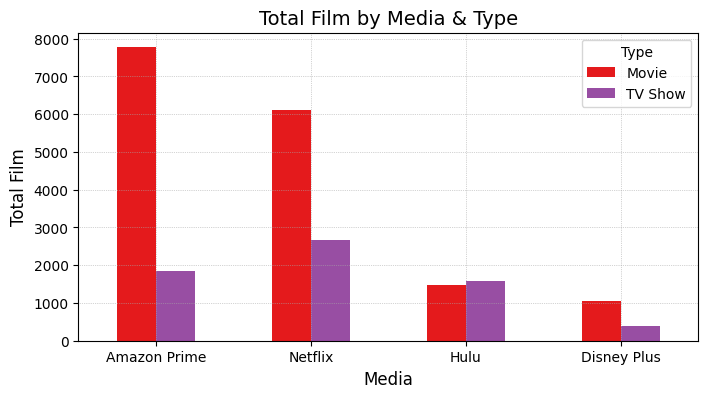

In [46]:
# How many total film by country and type
film_media_type = spark.sql("""
  SELECT
    media AS Media,
    type AS Type,
    COUNT(DISTINCT show_id) AS `Total Film`
  FROM MoviesAnalytics
  GROUP BY media, type
  ORDER BY `Total Film` DESC;
""")
film_media_type.show()

# Convert Spark DataFrame to Pandas DataFrame
film_media_type_pd = film_media_type.toPandas()

# Pivot the DataFrame to reorganize data by media and type
film_media_type_pivot = film_media_type_pd.pivot_table(
    index='Media',
    columns='Type',
    values='Total Film',
    aggfunc='sum'
)

# Add a column for total film and sort by it in descending order
film_media_type_pivot['Total Film'] = film_media_type_pivot.sum(axis=1)
film_media_type_pivot = film_media_type_pivot.sort_values('Total Film', ascending=False)

# Plot the data
color_palette = plt.cm.Set1([i / len(film_media_type_pivot.columns)
                             for i in range(len(film_media_type_pivot.columns))])

film_media_type_pivot.drop('Total Film', axis=1).plot(
    kind='bar',
    stacked=False,
    color=color_palette,
    figsize=(8, 4)
)

# Add plot details
plt.title('Total Film by Media & Type', fontsize=14)
plt.ylabel('Total Film', fontsize=12)
plt.xlabel('Media', fontsize=12)
plt.legend(title='Type')
plt.xticks(rotation=0, ha='center')
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
# Display the plot
plt.show()

+------------+-------+----------+
|Release Year|   Type|Total Film|
+------------+-------+----------+
|        2000|TV Show|        27|
|        2000|  Movie|       140|
|        2001|  Movie|       138|
|        2001|TV Show|        35|
|        2002|TV Show|        25|
|        2002|  Movie|       163|
|        2003|TV Show|        40|
|        2003|  Movie|       161|
|        2004|  Movie|       185|
|        2004|TV Show|        47|
|        2005|TV Show|        71|
|        2005|  Movie|       192|
|        2006|TV Show|        76|
|        2006|  Movie|       241|
|        2007|  Movie|       261|
|        2007|TV Show|        68|
|        2008|TV Show|        96|
|        2008|  Movie|       285|
|        2009|  Movie|       285|
|        2009|TV Show|       124|
+------------+-------+----------+
only showing top 20 rows



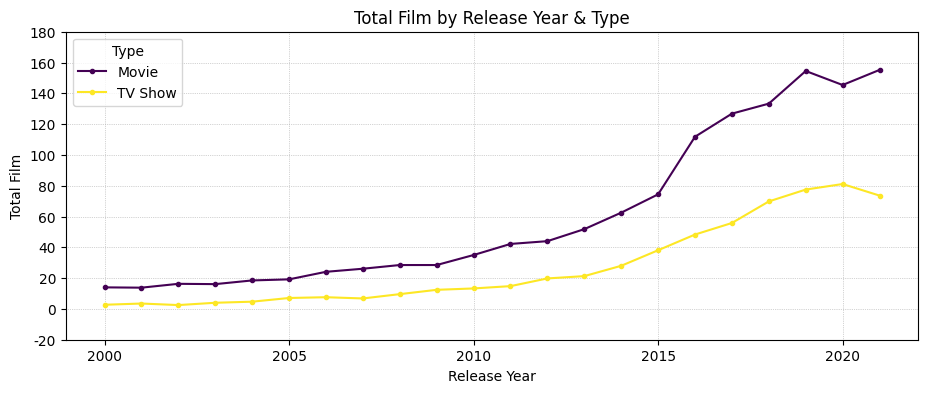

In [59]:
# How many total film by release year and type
film_release_type = spark.sql("""
  SELECT
    release_year AS `Release Year`,
    type AS Type,
    COUNT(DISTINCT show_id) AS `Total Film`
  FROM MoviesAnalytics
  WHERE release_year >= 2000
  GROUP BY release_year, type
  ORDER BY `Release Year`;
""")
film_release_type.show()

# Convert Spark DataFrame to Pandas DataFrame
film_release_type_pd = film_release_type.toPandas()
# Visualize Total Sales by Order Year & Product Category
film_release_type_pd.groupby(['Release Year', 'Type'])['Total Film'].sum().unstack().plot(marker = '.', cmap = 'viridis',
                                                                                                        figsize = (11,4))
plt.title('Total Film by Release Year & Type', loc = 'center')
plt.xlabel('Release Year')
plt.ylabel('Total Film')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 0.5)
labels, locations = plt.yticks()
plt.yticks(labels, (labels/10).astype(int))
plt.show()

+------------+------------+----------+
|Release Year|       Media|Total Film|
+------------+------------+----------+
|        2000|        Hulu|        23|
|        2000| Disney Plus|        26|
|        2000|     Netflix|        37|
|        2000|Amazon Prime|        81|
|        2001| Disney Plus|        18|
|        2001|     Netflix|        45|
|        2001|        Hulu|        28|
|        2001|Amazon Prime|        82|
|        2002|Amazon Prime|        92|
|        2002|        Hulu|        25|
|        2002|     Netflix|        51|
|        2002| Disney Plus|        21|
|        2003|        Hulu|        31|
|        2003| Disney Plus|        29|
|        2003|Amazon Prime|        81|
|        2003|     Netflix|        61|
|        2004| Disney Plus|        28|
|        2004|Amazon Prime|       103|
|        2004|        Hulu|        37|
|        2004|     Netflix|        64|
+------------+------------+----------+
only showing top 20 rows



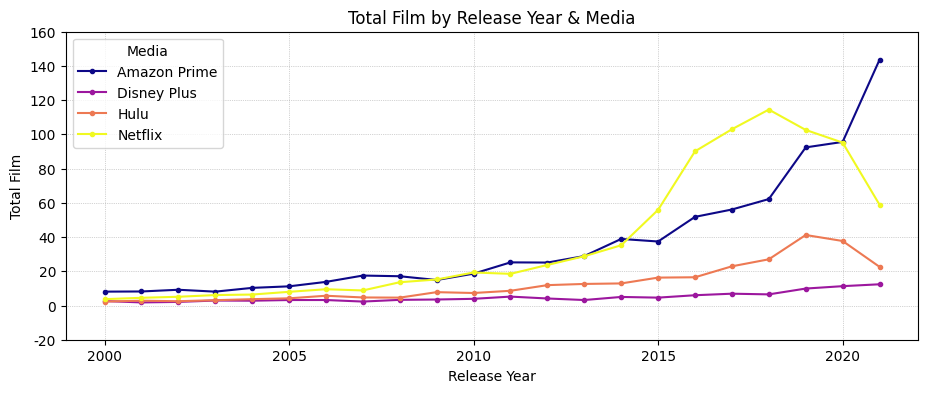

In [62]:
# How many total film by release year and media
film_release_media = spark.sql("""
  SELECT
    release_year AS `Release Year`,
    media AS Media,
    COUNT(DISTINCT show_id) AS `Total Film`
  FROM MoviesAnalytics
  WHERE release_year >= 2000
  GROUP BY release_year, media
  ORDER BY `Release Year`;
""")
film_release_media.show()

# Convert Spark DataFrame to Pandas DataFrame
film_release_media_pd = film_release_media.toPandas()
# Visualize Total Sales by Order Year & Product Category
film_release_media_pd.groupby(['Release Year', 'Media'])['Total Film'].sum().unstack().plot(marker = '.', cmap = 'plasma',
                                                                                                        figsize = (11,4))
plt.title('Total Film by Release Year & Media', loc = 'center')
plt.xlabel('Release Year')
plt.ylabel('Total Film')
plt.grid(color = 'darkgray', linestyle = ':', linewidth = 0.5)
labels, locations = plt.yticks()
plt.yticks(labels, (labels/10).astype(int))
plt.show()

+------------+----------+
|       Media|Total Film|
+------------+----------+
|Amazon Prime|      9615|
|     Netflix|      8787|
|        Hulu|      3073|
| Disney Plus|      1447|
+------------+----------+



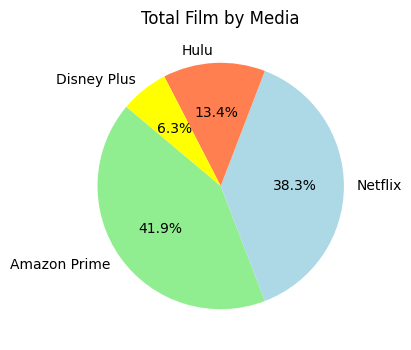

In [66]:
# How many total film by media
film_media = spark.sql("""
  SELECT
    media AS Media,
    COUNT(DISTINCT show_id) AS `Total Film`
  FROM MoviesAnalytics
  GROUP BY media
  ORDER BY `Total Film` DESC;
""")
film_media.show()

# Convert Spark DataFrame to Pandas DataFrame
film_media_pd = film_media.toPandas()

# Plotting the pie chart
plt.figure(figsize=(5, 4))
plt.pie(
    film_media_pd['Total Film'],
    labels=film_media_pd['Media'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightblue', 'coral', 'yellow'],  # Add more colors if necessary
    startangle=140
)
plt.title('Total Film by Media')
plt.show()

+-------+----------+
|   Type|Total Film|
+-------+----------+
|  Movie|      9223|
|TV Show|      4727|
+-------+----------+



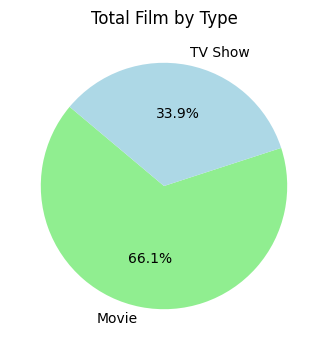

In [68]:
# How many total film by type
film_type = spark.sql("""
  SELECT
    type AS Type,
    COUNT(DISTINCT show_id) AS `Total Film`
  FROM MoviesAnalytics
  GROUP BY type
  ORDER BY `Total Film` DESC;
""")
film_type.show()

# Convert Spark DataFrame to Pandas DataFrame
film_type_pd = film_type.toPandas()

# Plotting the pie chart
plt.figure(figsize=(5, 4))
plt.pie(
    film_type_pd['Total Film'],
    labels=film_type_pd['Type'],
    autopct='%1.1f%%',
    colors=['lightgreen', 'lightblue'],  # Add more colors if necessary
    startangle=140
)
plt.title('Total Film by Type')
plt.show()